# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [31]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [32]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [33]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [34]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers (Linear, BatchNorm1d, Dropout, etc.)
        # self....
        # pass
        self.net = nn.Sequential(
            # 6 --> 16
            nn.Linear(input_dim, h1),     # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h1),        # <-- batch norm (stability/regularization)
            nn.ReLU(),                         # <-- nonlinearity
            nn.Dropout(p_drop),             # <-- dropout regularization
            # 16 --> 8
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(), 
            nn.Dropout(p_drop), 
            # 8 --> 4
            nn.Linear(h2, out_dim)           # <-- output (linear for regression)
        )
        
    def forward(self, x):
        # TODO: implement forward pass
        # pass
        return self.net(x)


In [35]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

# model = DNN_Reg4(...).to(device)
# loss_fn = ...
# optimizer = ...
model = DNN_Reg4(
    input_dim=INPUT_DIM, 
    h1=H1, 
    h2=H2, 
    out_dim=OUT_DIM, 
    p_drop=DROPOUT_P
).to(device)
loss_fn = nn.MSELoss()  # <-- regression loss
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)  # <-- L2

In [36]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            opt.zero_grad() # TODO: zero gradients
            pred = model(xb) # TODO: forward pass
            loss = loss_fn(pred, yb) # TODO: compute loss
            loss.backward() # TODO: backward
            opt.step() # TODO: optimizer step

            total += loss.item() * xb.size(0) # total += loss.item() * xb.size(0)
            # pass

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep:4d} | Average Train MSE: {avg_loss:.6f}")
            # pass

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# TODO: Train the model
train_part1(model, train_loader_1)

Epoch    1 | Average Train MSE: 0.766126
Epoch  500 | Average Train MSE: 0.103133
Epoch 1000 | Average Train MSE: 0.102652


In [37]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8848    0.7850    0.8319      2377
           C     0.9919    0.9178    0.9534      2263
           B     0.9452    0.9653    0.9552      3057
           A     0.9778    0.9800    0.9789      3144

   micro avg     0.9522    0.9201    0.9359     10841
   macro avg     0.9499    0.9120    0.9298     10841
weighted avg     0.9512    0.9201    0.9347     10841
 samples avg     0.6595    0.6498    0.6489     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2882  243]
 [ 511 1866]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3222   17]
 [ 186 2077]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2274  171]
 [ 106 2951]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2288   70]
 [  63 3081]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8894    0.7733    0.8273      1019
           C     0.9856    

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sk

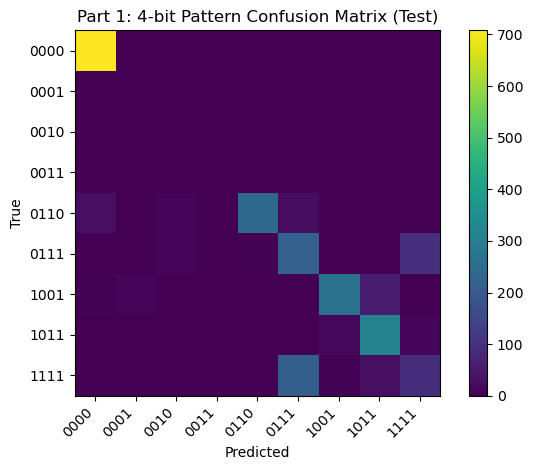

[[708   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 28   0  11   0 238  24   0   0   0]
 [  0   0  11   0   4 217   0   0  97]
 [  4  12   0   0   0   0 266  57   0]
 [  0   0   0   1   0   0  14 312  13]
 [  0   0   0   0   0 214   4  29  93]]


In [38]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [39]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [40]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        # pass
        self.net = nn.Sequential(
            # 6 -> 16
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            
            #  16 -> 8
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            
            # 8 -> 4
            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        # TODO: forward pass returning logits (N,4)
        # pass
        return self.net(x)


In [41]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...
model_2 = DNN_MultiLabel4(
    input_dim=INPUT_DIM, 
    h1=H1, 
    h2=H2, 
    out_dim=OUT_DIM, 
    p_drop=DROPOUT_P
).to(device)

loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [42]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step
            optimizer_2.zero_grad()
            pred = model(xb)
            loss = loss_fn_2(pred, yb)
            loss.backward()
            optimizer_2.step()

            total += loss.item() * xb.size(0) # total += loss.item() * xb.size(0)
            # pass

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep:4d} | Average Train BCE Loss: {avg_loss:.6f}")
            # pass

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part2(model_2, train_loader_2)

Epoch    1 | Average Train BCE Loss: 0.708954
Epoch  500 | Average Train BCE Loss: 0.218229
Epoch 1000 | Average Train BCE Loss: 0.200337


In [43]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.4320    1.0000    0.6034      2377
           C     0.4122    1.0000    0.5838      2263
           B     0.5556    1.0000    0.7143      3057
           A     0.5714    1.0000    0.7273      3144

   micro avg     0.4929    1.0000    0.6603     10841
   macro avg     0.4928    1.0000    0.6572     10841
weighted avg     0.5032    1.0000    0.6665     10841
 samples avg     0.4930    0.6992    0.5685     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[   0 3125]
 [   0 2377]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[  12 3227]
 [   0 2263]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[   0 2445]
 [   0 3057]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[   0 2358]
 [   0 3144]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.4320    1.0000    0.6033      1019
           C     0.4128    

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


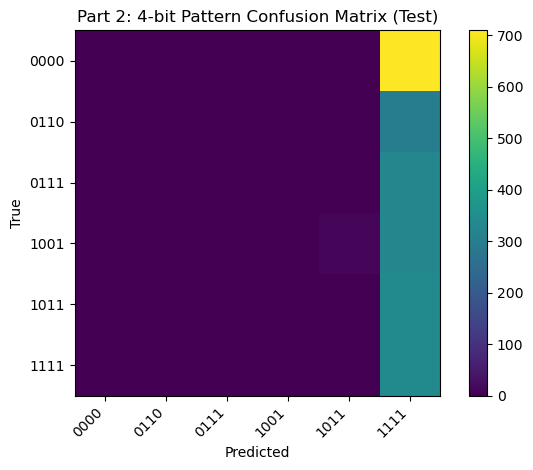

[[  0   0   0   0   0 710]
 [  0   0   0   0   0 301]
 [  0   0   0   0   0 329]
 [  0   0   0   0   9 330]
 [  0   0   0   0   0 340]
 [  0   0   0   0   0 340]]


In [44]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [45]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [46]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            # 6 -> 16
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            
            # 16 -> 8
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            
            # 8 -> 6 
            nn.Linear(h2, num_classes)
        )
        # pass

    def forward(self, x):
        # TODO: forward pass returning logits (N,6)
        # pass
        return self.net(x)

In [47]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model_3 = DNN_MultiClass6(input_dim=INPUT_DIM, h1=H1, h2=H2, 
                          num_classes=6, p_drop=DROPOUT_P).to(device)
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(
    model_3.parameters(), 
    lr=LR, 
    weight_decay=L2_WEIGHT_DECAY
)

In [48]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step
            optimizer_3.zero_grad()
            logits = model_3(xb) # shape: (batch_size, C)
            loss = loss_fn_3(logits, yb)
            loss.backward()
            optimizer_3.step()

            total += loss.item() * xb.size(0)
            # total += loss.item() * xb.size(0)
            # pass

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep:4d} | Average Train CrossEntropy: {avg_loss:.6f}")
            # pass

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model_3, train_loader_3)

Epoch    1 | Average Train CrossEntropy: 1.851715
Epoch  500 | Average Train CrossEntropy: 0.596694
Epoch 1000 | Average Train CrossEntropy: 0.603776



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.0000    0.0000    0.0000      1655
          LG     0.0000    0.0000    0.0000       790
          LL     0.1386    0.6430    0.2280       703
         LLG     0.4811    0.9924    0.6480       794
         LLL     0.0000    0.0000    0.0000       767
        LLLG     0.0000    0.0000    0.0000       793

    accuracy                         0.2254      5502
   macro avg     0.1033    0.2726    0.1460      5502
weighted avg     0.0871    0.2254    0.1226      5502



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


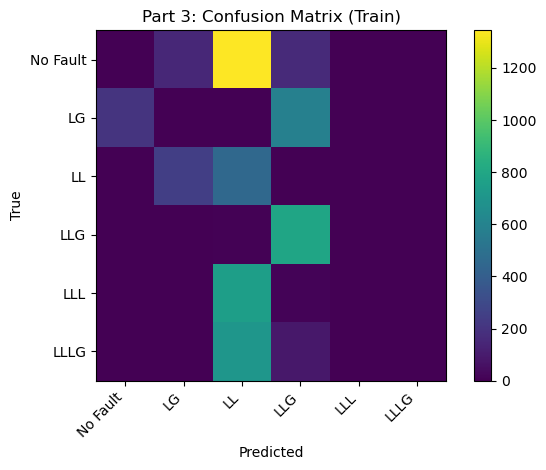


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.0000    0.0000    0.0000       710
          LG     0.0000    0.0000    0.0000       339
          LL     0.1365    0.6279    0.2242       301
         LLG     0.4878    1.0000    0.6557       340
         LLL     0.0000    0.0000    0.0000       329
        LLLG     0.0000    0.0000    0.0000       340

    accuracy                         0.2242      2359
   macro avg     0.1040    0.2713    0.1467      2359
weighted avg     0.0877    0.2242    0.1231      2359



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


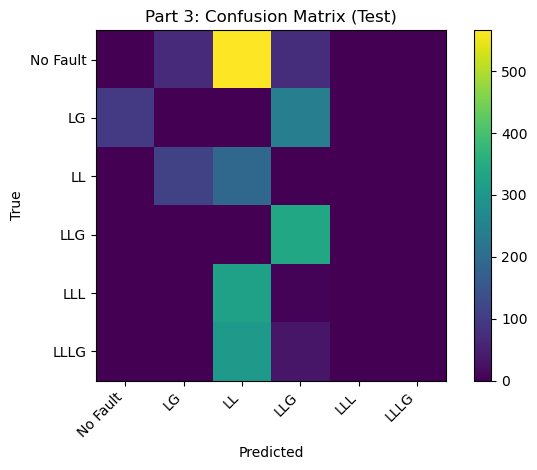

In [49]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1: Regression-style fits this dataset best. It shows a micro-average F1-score of 0.9332 and has the highest overall performance  
- Q2: Yes, I observed invalid fault patterns in Part 1 and Part 2. In Part 2, the recall is 1.0000 for every bit, while the precision is low (around 0.5). This suggests the model is over-predicting faults; it treats each bit as an independent variable.
- Q3: In Part 3, the LG , LLL , and LLLG faults were the hardest to predict, as evidenced by their 0.0000 F1-scores. This indicates the model failed to identify these categories entirely. This was likely caused by class imbalance.

## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [50]:
scaler_5 = RobustScaler()
X_train_s5 = scaler_5.fit_transform(X_train).astype(np.float32)
X_test_s5  = scaler_5.transform(X_test).astype(np.float32)

# Convert 0-5 labels to Binary (0 = No Fault, 1 = Fault)
y_train_b = (y_fault_train > 0).astype(np.float32)
y_test_b  = (y_fault_test > 0).astype(np.float32)

Xtr5 = torch.from_numpy(X_train_s5)
Xte5 = torch.from_numpy(X_test_s5)
ytr5 = torch.from_numpy(y_train_b)
yte5 = torch.from_numpy(y_test_b)

train_loader_5 = DataLoader(TensorDataset(Xtr5, ytr5), batch_size=BATCH_SIZE, shuffle=True)

In [51]:
class BinaryFaultDetector(nn.Module):
    def __init__(self, input_dim=6, h1=16, h2=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Linear(h2, 1) # Single output for binary
        )
    def forward(self, x):
        return self.net(x)

model_5 = BinaryFaultDetector().to(device)
loss_fn_5 = nn.BCEWithLogitsLoss()
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=LR, weight_decay=1e-4)

In [52]:
def train_part5(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yb = yb.view(-1, 1)
            
            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step
            optimizer_5.zero_grad()
            logits = model_5(xb) # shape: (batch_size, C)
            loss = loss_fn_5(logits, yb)
            loss.backward()
            optimizer_5.step()

            total += loss.item() * xb.size(0)
            # total += loss.item() * xb.size(0)
            # pass

        if ep in [1, epochs//2, epochs]:
            avg_loss = total / len(loader.dataset)
            print(f"Epoch {ep:4d} | Average Train CrossEntropy: {avg_loss:.6f}")
            # pass

@torch.no_grad()
def predict_part5(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits)
    return (probs > 0.5).cpu().numpy().astype(int).flatten()

# TODO: Train the model
train_part5(model_5, train_loader_5)

Epoch    1 | Average Train CrossEntropy: 0.598402
Epoch  500 | Average Train CrossEntropy: 0.029280
Epoch 1000 | Average Train CrossEntropy: 0.026541



=== Part 5 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9839    0.9994    0.9916      1655
       Fault     0.9997    0.9930    0.9963      3847

    accuracy                         0.9949      5502
   macro avg     0.9918    0.9962    0.9940      5502
weighted avg     0.9950    0.9949    0.9949      5502



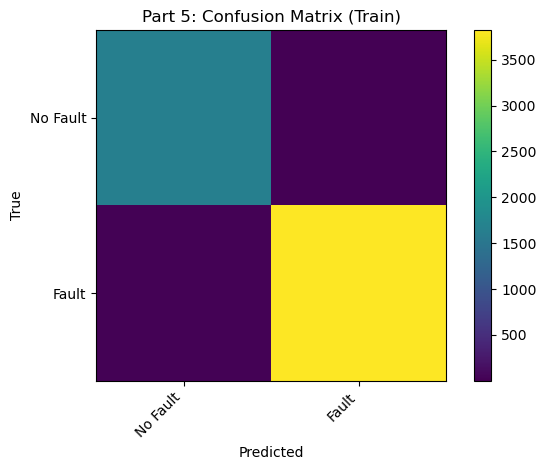


=== Part 5 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9834    1.0000    0.9916       710
       Fault     1.0000    0.9927    0.9963      1649

    accuracy                         0.9949      2359
   macro avg     0.9917    0.9964    0.9940      2359
weighted avg     0.9950    0.9949    0.9949      2359



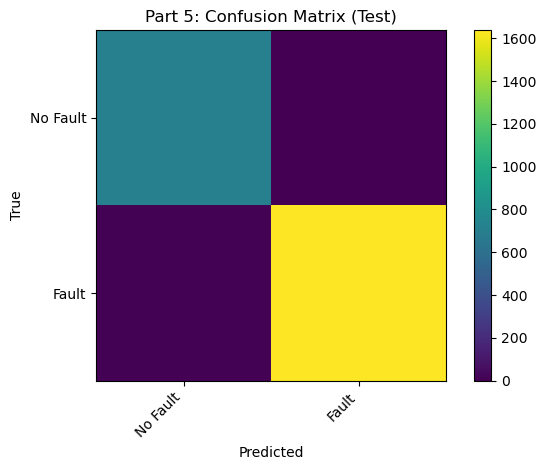

In [53]:
# ----------------------------
# Evaluation
# ----------------------------
BINARY_NAMES = ['No Fault', 'Fault']

pred_train = predict_part5(model_5, X_train_s5)
pred_test  = predict_part5(model_5, X_test_s5)

print('\n=== Part 5 | Train ===')
print(classification_report(y_train_b, pred_train, target_names=BINARY_NAMES, digits=4))
cm_tr = confusion_matrix(y_train_b, pred_train)
plot_cm(cm_tr, 'Part 5: Confusion Matrix (Train)', BINARY_NAMES)

print('\n=== Part 5 | Test ===')
print(classification_report(y_test_b, pred_test, target_names=BINARY_NAMES, digits=4))
cm_te = confusion_matrix(y_test_b, pred_test)
plot_cm(cm_te, 'Part 5: Confusion Matrix (Test)', BINARY_NAMES)